<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Copy_of_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
#import jyquickhelper
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
from collections import Counter


# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import plotly.graph_objects as go

# Modèle
import sklearn
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
# Standardisation
from sklearn.preprocessing import StandardScaler


# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep

In [ ]:
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def reduce_mem_usage(data, verbose=True):
    # source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-' * 79)
        print('Memory usage du dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        #  Float et int
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(
                        np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

        # # Boolean : pas à faire car pour machine learning il faut des int 0/1
        # et pas False/True
        # if list(data[col].unique()) == [0, 1] or list(data[col].unique()) == [1, 0]:
        #     data[col] = data[col].astype(bool)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage après optimization: {:.2f} MB'.format(end_mem))
        print('Diminution de {:.1f}%'.format(
            100 * (start_mem - end_mem) / start_mem))
        print('-' * 79)

    return data

In [4]:
# Original Dataset 
#application_train = pd.read_csv('/content/drive/MyDrive/p7/data/application_train.csv')
application_test = pd.read_csv('/content/drive/MyDrive/p7/data/application_test.csv')

In [ ]:
application_train.shape, application_test.shape

((307511, 122), (48744, 121))

In [5]:
# dataset after preprocesing

train_set = pd.read_csv('/content/drive/MyDrive/p7/data/data_train.csv')
test_set = pd.read_csv('/content/drive/MyDrive/p7/data/data_test.csv')

In [ ]:
test_set.shape

(48744, 896)

## Scoring (prédictions/Probabilités)

In [42]:
# Copie du jeu de test
test = test_set.copy(deep=True)
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = test['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = test.drop('SK_ID_CURR', axis=1)

In [9]:
X_test.shape

(48744, 895)

In [10]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [11]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [12]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = best_model.predict(X_test)

In [13]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%
0,100001,0,0.346507,34.7
1,100005,0,0.381842,38.2
2,100013,0,0.108651,10.9


In [14]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard = df_score.merge(test_set, on='SK_ID_CURR', how='left')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NEW_INSTALLMENTS_PER_LOAN_MIN,CC_NEW_INSTALLMENTS_PER_LOAN_MAX,CC_NEW_INSTALLMENTS_PER_LOAN_MEAN,CC_NEW_INSTALLMENTS_PER_LOAN_SUM,CC_NEW_INSTALLMENTS_PER_LOAN_VAR,CC_COUNT
0,100001,0,0.346507,34.7,0,0,0,0,135000.0,568800.0,...,0.0,0.0,0.0,0.0,27.0,27.0,27.0,810.0,0.0,30.0
1,100005,0,0.381842,38.2,1,0,0,0,99000.0,222768.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,35.0,0.0,7.0
2,100013,0,0.108651,10.9,1,1,0,0,202500.0,663264.0,...,0.0,0.0,0.0,0.0,25.0,25.0,25.0,2075.0,0.0,83.0


In [15]:
df_dashboard.shape

(48744, 899)

In [16]:
# Sauvegarde de df_dashboard
fic_sav_df_dashboard ='/content/drive/MyDrive/p7/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# Chargement du dataframe df_dashboard_1
fic_sav_df_dashboard_1 ='/content/drive/MyDrive/p7/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'rb') as df_dashboard_1:
    df_dashboard = pickle.load(df_dashboard_1)
df_dashboard.shape

(48744, 899)

4. **Préparation des données informatives**

Customer Information

Informative data on the customer to be made available and readable for the account manager:

In [18]:
df_infos =application_test[['SK_ID_CURR',
                           'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

,SK_ID_CURR,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working


In [19]:
df_infos.shape

(48744, 9)

In [20]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboardcc = df_dashboard.merge(df_infos, on='SK_ID_CURR', how='right')
df_dashboardcc.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN_x,AMT_INCOME_TOTAL_x,AMT_CREDIT,...,CC_NEW_INSTALLMENTS_PER_LOAN_VAR,CC_COUNT,AMT_INCOME_TOTAL_y,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN_y,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,0,0.346507,34.7,0,0,0,0,135000.0,568800.0,...,0.0,30.0,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,0,0.381842,38.2,1,0,0,0,99000.0,222768.0,...,0.0,7.0,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,0,0.108651,10.9,1,1,0,0,202500.0,663264.0,...,0.0,83.0,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working


dtype('int8')

In [21]:
df_dashboardcc['YEAR_BIRTH']= np.trunc(np.abs(df_dashboard['DAYS_BIRTH'] / 365)).astype('int8')

In [22]:
df_dashboard.shape

(48744, 899)

In [23]:
df_dashboard[df_dashboard==np.inf]=np.nan

In [24]:
# Transformer DAYS_EMPLOYED en années positives
df_dashboard['YEAR_EMPLOYED'] = np.abs(df_dashboard['DAYS_EMPLOYED'] / 365)
 

In [25]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_dashboard['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                        for row in df_dashboard['CODE_GENDER']] 

In [26]:
# Sauvegarde de df_dashboard_2
fic_sav_df_dashboard ='/content/drive/MyDrive/p7/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [27]:
# Chargement du dataframe df_dashboard_2
fic_sav_df_dashboard_2 ='/content/drive/MyDrive/p7/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard_2, 'rb') as df_dashboard_2:
    df_dashboard = pickle.load(df_dashboard_2)
df_dashboard.shape

(48744, 901)

**4.2. Variables ayant le plus d'importance sur le modèle**

Les variables ayant le plus d'importance sur le modèle constituent les variables à comparer pour situer notre client par rapport à la moyenne des valeurs de ces variables pour tous les clients et comparer ces valeurs avec celles des 10 plus proches voisins qui ont des valeurs similaires à notre client.
Le but est de tracer un lineplot pour chacune de ces variables déterminantes pour comparer les valeurs du client, les valeurs moyennes sur l'ensemble des clients et les valeurs des 10 plus proches voisins séparés en 2 groupes : défaillant et non-défaillant.
**Variables à comparer ?**

**Features importances**

D'après le notebook sur la modélisation, les 10 variables issus de l'analyse des features importances ayant le plus d'impact sur le meilleur modèle sont :

[X] CREDIT_ANNUITY RATIO

[x] EXT_SOURCE_SUM

[X] INST_PAY_DAYS_PAYMENT_RATIO_MAX

[X] PREV_APP_INTEREST_SHARE_MAX

[X] EXT_SOURCE_1

[X] CREDIT_GOODS_RATIO

[X] CODE GENDER

[X] INST_PAY_AMT_INSTALMENT_SUM

[X] EXT_SOURCE_2

[X] DAYS_BIRTH

[X] AMT_ANNUITY

[X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN

**Shapley values globales**

In [28]:
feature_importances = pickle.load( open('drive/MyDrive/p7/feature_importances.sav', 'rb'))
fi= feature_importances.head(20)
fi.feature

94                 NEW_ANNUITY_CREDIT_RATIO
29                             EXT_SOURCE_3
95                             NEW_EXT_MEAN
28                             EXT_SOURCE_2
27                             EXT_SOURCE_1
12                              OWN_CAR_AGE
6                               AMT_ANNUITY
9                             DAYS_EMPLOYED
8                                DAYS_BIRTH
90                   NEW_DAYS_EMPLOYED_PERC
5                                AMT_CREDIT
96                             NEW_EXT_PROD
97                                  NEW_AGE
11                          DAYS_ID_PUBLISH
0                               CODE_GENDER
10                        DAYS_REGISTRATION
59                   DAYS_LAST_PHONE_CHANGE
117    NAME_EDUCATION_TYPE_Higher education
100           NAME_CONTRACT_TYPE_Cash loans
93                  NEW_ANNUITY_INCOME_PERC
Name: feature, dtype: object

In [ ]:
pd.set_option('display.max_rows', None)
 
# storing the dataset as data frame
dataframe = pd.DataFrame(fi.feature, columns = fi.feature)
 
# printing data frame
print(dataframe)

Empty DataFrame
Columns: [NEW_ANNUITY_CREDIT_RATIO, EXT_SOURCE_3, NEW_EXT_MEAN, EXT_SOURCE_2, EXT_SOURCE_1, OWN_CAR_AGE, AMT_ANNUITY, DAYS_EMPLOYED, DAYS_BIRTH, NEW_DAYS_EMPLOYED_PERC, AMT_CREDIT, NEW_EXT_PROD, NEW_AGE, DAYS_ID_PUBLISH, CODE_GENDER, DAYS_REGISTRATION, DAYS_LAST_PHONE_CHANGE, NAME_EDUCATION_TYPE_Higher education, NAME_CONTRACT_TYPE_Cash loans, NEW_ANNUITY_INCOME_PERC]
Index: []


In [29]:
# Liste des variables les plus déterminantes
feat_imp = ['NEW_ANNUITY_CREDIT_RATIO', 
            'EXT_SOURCE_3', 
            'NEW_EXT_MEAN', 
            'EXT_SOURCE_2', 
            'EXT_SOURCE_1', 
            'OWN_CAR_AGE', 
            'AMT_ANNUITY', 
            'DAYS_EMPLOYED', 
            'DAYS_BIRTH', 
            'NEW_DAYS_EMPLOYED_PERC', 
            'AMT_CREDIT', 
            'NEW_EXT_PROD', 
            'NEW_AGE', 
            'DAYS_ID_PUBLISH', 
            'CODE_GENDER', 
            'DAYS_REGISTRATION', 
            'DAYS_LAST_PHONE_CHANGE',
            'NAME_EDUCATION_TYPE_Higher education', 
            'NAME_CONTRACT_TYPE_Cash loans', 
            'NEW_ANNUITY_INCOME_PERC']


**AMT_ANNUITY**

Annuité de prêt

**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**

Valeur minimale de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit

**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN**

Valeur moyenne de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit

**BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN**

Moyenne du ratio des prêts précédents sur d'autres institution de : la dette actuelle sur le crédit et la limite de crédit actuelle de la carte de crédit

**CAR_EMPLOYED_RATIO**

Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la date de la demande

**CODE_GENDER**

Sexe

**CREDIT_ANNUITY_RATIO**

Ratio : montant du crédit du prêt / Annuité de prêt

**CREDIT_GOODS_RATIO**

Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé / Crédit est supérieur au prix des biens ?

**DAYS_BIRTH**

Âge

**DAYS_ID_PUBLISH**

Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt ?

**EXT_SOURCE_1**

Source externe normalisée

**EXT_SOURCE_2**

Source externe normalisée

**EXT_SOURCE_3**

Source externe normalisée

In [30]:
# Matrice X - variables les plus déterminantes
X = train_set[feat_imp]

In [31]:
# Vecteur y
# y = df_dashboard['SCORE_CLIENT'].astype('int64')
y = train_set['TARGET']
y.shape

(307507,)

In [32]:
# Matrice X_test - variables les plus déterminantes
X_test = test_set[feat_imp]

In [33]:
# Vecteur y
y_test = df_dashboard['SCORE_CLIENT'].astype('int64')
y_test.shape

(48744,)

In [43]:
X_test.shape

(48744, 895)

4.2.2. 10 voisins les plus proches du train set

**10 voisins les plus proches du train set**

In [41]:
import pickle
best_model = pickle.load(open('/content/drive/MyDrive/p7/best_model.sav', 'rb'))
best_model

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.78, force_col_wise=True, max_depth=10,
               min_child_samples=54, min_child_weight=42, min_split_gain=0.015,
               num_leaves=35, objective='binary', reg_alpha=0.28,
               reg_lambda=0.03, seed=0, subsample=0.2)

In [40]:
# Entraînement du modèle
best_model.fit(X_test, y)

LightGBMError: ignored

In [ ]:
# Sauvegarde du modèle entraîné
fic_knn ='/content/drive/MyDrive/p7/dashboard/knn_10_voisins_train.pickle'
with open(fic_knn, 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Récupération des index des 10 voisins similaires
liste_index_10_voisins = knn.kneighbors(X_test_std)[1]

In [ ]:
# Index des 10 clients voisins dans le train set
df_dashboard['INDEX_10_VOISINS_TRAIN'] = \
    [index for index in liste_index_10_voisins]

In [ ]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [Counter(train_set['TARGET'].iloc[index])[1]
     for index in liste_index_10_voisins]

In [ ]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN']]

In [34]:
df_dashboard[['SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TRAIN']].head(10)

KeyError: ignored

In [ ]:
# Sauvegarde de df_dashboard_3
fic_sav_df_dashboard_3 ='/content/drive/MyDrive/p7/dashboard/df_dashboard_3.pickle'
with open(fic_sav_df_dashboard_3, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement du dataframe df_dashboard_3
fic_sav_df_dashboard_3 ='/content/drive/MyDrive/p7/dashboard/df_dashboard_3.pickle'
with open(fic_sav_df_dashboard_3, 'rb') as df_dashboard_3:
    df_dashboard = pickle.load(df_dashboard_3)
df_dashboard.shape

(48744, 904)

Constitution du dataframe des voisins pour le dashboard

In [ ]:
df_index_voisins = \
    pd.DataFrame({'ID_CLIENT' : test_set['SK_ID_CURR'],
                  'INDEX_10_VOISINS' : liste_index_10_voisins.tolist()})
df_index_voisins.shape

(48744, 2)

In [ ]:
# Sauvegarde de df_index_voisins
fic_sav_df_index_voisins ='/content/drive/MyDrive/p7/dashboard/df_index_voisins.pickle'
with open(fic_sav_df_index_voisins, 'wb') as f:
    pickle.dump(df_index_voisins, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement du dataframe df_index_voisins
fic_sav_df_index_voisins ='/content/drive/MyDrive/p7/dashboard/df_index_voisins.pickle'
with open(fic_sav_df_index_voisins, 'rb') as df_index_voisins:
    df_index_voisins = pickle.load(df_index_voisins)
df_index_voisins.shape

(48744, 2)

In [ ]:
df_voisin_train = pd.DataFrame({})

In [ ]:
# Chargement du dataframe df_voisin_train
fic_sav_df_voisin_train ='/content/drive/MyDrive/p7/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(0, 0)

In [ ]:
# Ajout SEXE : de CODE_GENDER : 0 = Féminin et 1 = Masculin
df_voisin_train['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                           for row in df_voisin_train['CODE_GENDER']] 

In [ ]:
# Ajout de la variable cible
df_voisin_train['TARGET'] = [train_set.loc[index, 'TARGET']
                             for index in df_voisin_train['INDEX_VOISIN']]

Réduction de la taille des variables pour optimisation mémoire

In [ ]:
df_voisin_train = reduce_mem_usage(df_voisin_train)

Sauvegarde du dataframe des voisins dans le train set

In [ ]:
# Sauvegarde du dataframe des 10 voisins du train set
fic_sav_df_voisins_train = '../sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisins_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

5.3. **Score du client**

Prédiction pour un client

In [44]:
# Sélection des variables du clients
client_id = 100001
X_test = test_set[test_set['SK_ID_CURR'] == client_id]
X_test

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NEW_INSTALLMENTS_PER_LOAN_MIN,CC_NEW_INSTALLMENTS_PER_LOAN_MAX,CC_NEW_INSTALLMENTS_PER_LOAN_MEAN,CC_NEW_INSTALLMENTS_PER_LOAN_SUM,CC_NEW_INSTALLMENTS_PER_LOAN_VAR,CC_COUNT
0,100001,0,0,0,0,135000.0,568800.0,20560.5,0.01885,-19241,...,0.0,0.0,0.0,0.0,27.0,27.0,27.0,810.0,0.0,30.0


In [45]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test.drop('SK_ID_CURR', axis=1))[:, 1]

In [46]:
# Score du client en pourcentage arrondi et nombre entier
y_proba_client = int(np.rint(y_proba * 100))
y_proba_client

35

In [47]:
fig = go.Figure(go.Indicator(
    mode = 'gauge+number+delta',
    # Score du client en % df_dashboard['SCORE_CLIENT_%']
    value = y_proba_client,  
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': 'Crédit score du client', 'font': {'size': 24}},
    # Score des 10 voisins test set
    # df_dashboard['SCORE_10_VOISINS_MEAN_TEST']
    delta = {'reference': 76,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    gauge = {'axis': {'range': [None, 100],
                      'tickwidth': 3,
                      'tickcolor': 'darkblue'},
             'bar': {'color': 'white', 'thickness' : 0.25},
             'bgcolor': 'white',
             'borderwidth': 2,
             'bordercolor': 'gray',
             'steps': [{'range': [0, 25], 'color': 'Green'},
                       {'range': [25, 49.49], 'color': 'LimeGreen'},
                       {'range': [49.5, 50.5], 'color': 'red'},
                       {'range': [50.51, 75], 'color': 'Orange'},
                       {'range': [75, 100], 'color': 'Crimson'}],
             'threshold': {'line': {'color': 'white', 'width': 10},
                           'thickness': 0.8,
                           # Score du client en %
                           # df_dashboard['SCORE_CLIENT_%']
                           'value': y_proba_client}}))

fig.update_layout(paper_bgcolor='white',
                  height=400, width=600,
                  font={'color': 'darkblue', 'family': 'Arial'})

fig.show()


In [48]:
# Test set sans l'identifiant
X_test = test_set.set_index('SK_ID_CURR')

In [51]:
! pip install shap
import shap

In [52]:
# Entraînement de shap sur le train set
shap_explainer = shap.Explainer(best_model, X_test)
shap_values = shap_explainer(X_test, check_additivity=False)

100%|===================| 48606/48744 [05:18<00:00]       

In [54]:
# Sauvegarde du shap explainer
filename = '/content/drive/MyDrive/p7/dashboard/shap_explainer.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_explainer, outfile)
outfile.close()

In [55]:
# Sauvegarde des shap values 
filename = '/content/drive/MyDrive/p7/dashboard/shap_values.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_values, outfile)
outfile.close()

In [56]:
# SHAP values
shap_values.values.shape

(48744, 895)

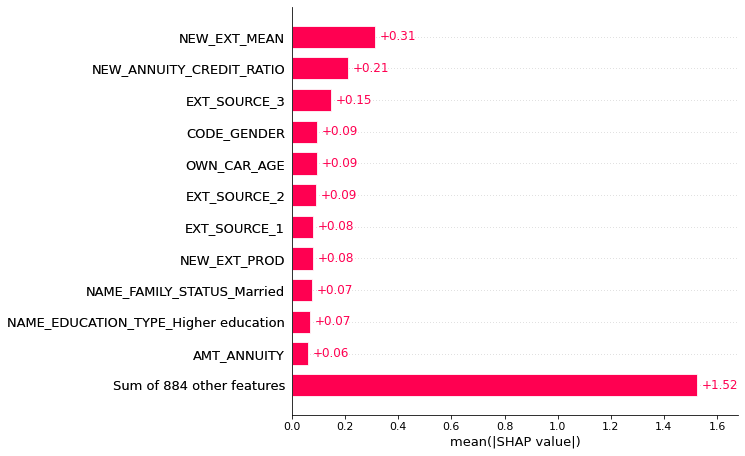

In [57]:
shap.plots.bar(shap_values, max_display=12)

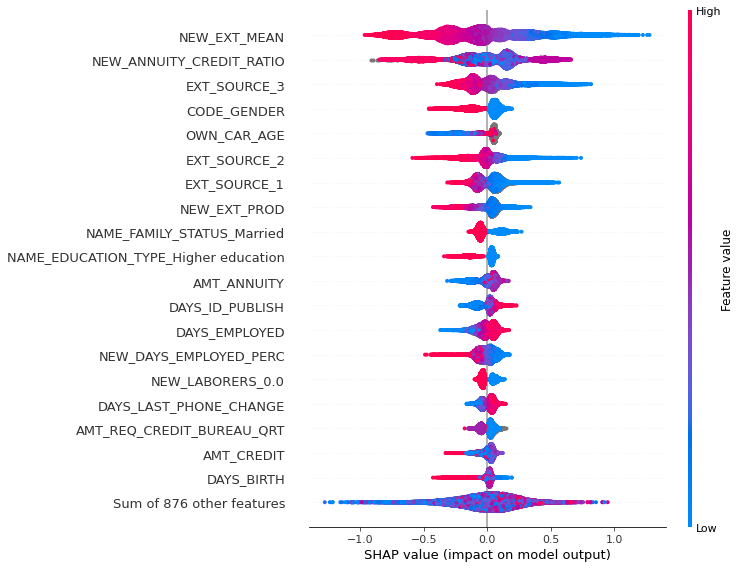

In [58]:
shap.plots.beeswarm(shap_values, max_display=20)

In [59]:
client_index = test_set[test_set['SK_ID_CURR'] == 100005].index.item()

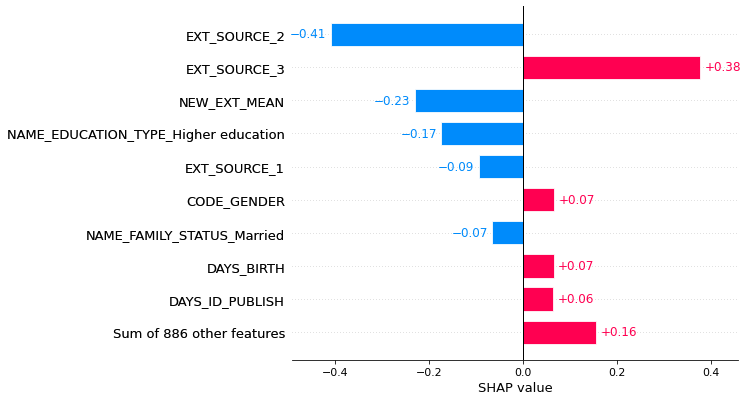

In [60]:
shap.plots.bar(shap_values[0])

Waterfall Plot

In [61]:
client_index = test_set[test_set['SK_ID_CURR'] == 100001].index.item()

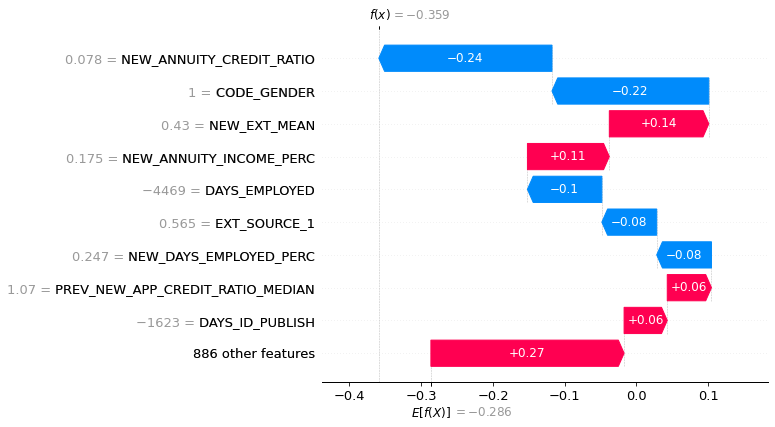

In [62]:
# Classe négative
shap.plots.waterfall(shap_values[1])

**ForcePlot**

In [66]:
explainer_0 = shap.TreeExplainer(best_model)

In [67]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

In [68]:
shap_values_0 = explainer_0.shap_values(X_test_0_array)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [69]:
# Plot SHAP force_plot [1] pour classe positive
shap.initjs()
shap.force_plot(explainer_0.expected_value[1], shap_values_0[1],
                X_test_0)

**Decision Plot**

Client 100001

In [72]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

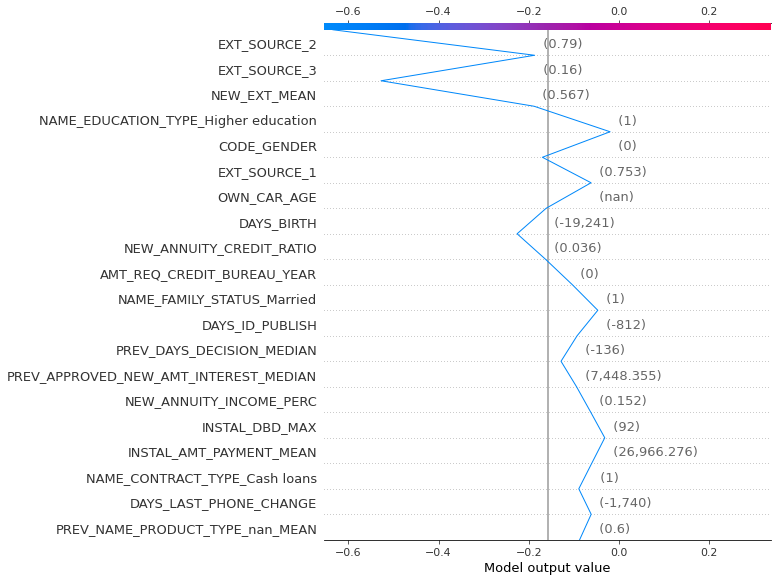

In [74]:
# Decision plot classe négative
shap.decision_plot(explainer_0.expected_value[1], shap_values_0[1],
                   X_test_0)

Client 100005

In [75]:
X_test_1 = X_test.iloc[1]
X_test_1_array = X_test_1.values.reshape(1, -1)

In [76]:
shap_values_1 = explainer.shap_values(X_test_1_array)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


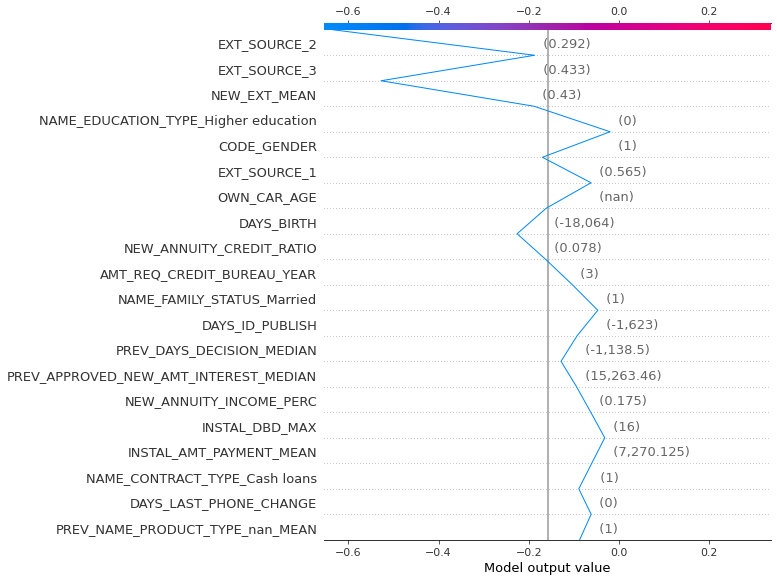

In [77]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_1)

Export de application_test pour affichage dashboard

In [ ]:
application_test = pd.read_csv('../data/application_test.csv')

In [ ]:
filename =  '../sauvegarde/pickle/application_test.pickle'
outfile = open(filename,'wb')
pickle.dump(application_test, outfile)
outfile.close()